Point velocity from ablation stake coordinates as measured during Rapid Static surveys

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib
import geopandas
import math

loc = '/home/pelto/Desktop/ice_flux/Kokanee/'

f_in = 'stakes_vel.csv'    #'conrad_points.csv' 

In [4]:
data = pd.read_csv(loc + f_in)
# data[0:10]
data

,ID,Elev,Easting,Northing,Velocity,year
0,KST50,2364,490109,5511350,7.500000,2018
1,KST55,2309,490046,5511471,3.000000,2018
2,KST40,2509,490030,5510934,2.000000,2016
3,KST45,2459,490111,5511145,6.000000,2016
4,KST50,2364,490109,5511350,5.000000,2016
5,KST55L,2333,490046,5511471,10.000000,2016
6,KST25N,2630,489665,5510847,8.000000,2019
7,KST35,2530,489923,5510888,11.666667,2019
8,KST40,2478,490030,5510934,4.250000,2019
9,KST45,2442,490111,5511145,11.000000,2019


In [6]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.features import rasterize
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error as MSE
import pwlf
import math
from scipy import stats
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import statsmodels.formula.api as smf
from hydroeval import *

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in less


1.9179688
3.2151186


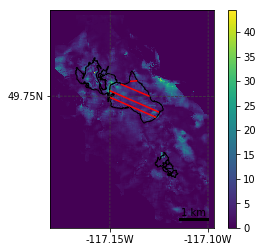

In [25]:
years =[2016,2017,2018]
yr=1
balance = 'Ba'  # Bw or Ba (winter or annual)
# rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = years[yr] # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs

vcorr=False ## is velocity corrected by off ice bias and stake bias?

gl = 0 # number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
glacier = ['kokanee', 'conrad', 'illecillewaet']
d = 20. #20.  #distance (m) between flux gate points
Dint = 0.9 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
sHopt = 0.1 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)
cb = 8 ##center bin use this to assure flux in is from bins cb+1 and cb+2
fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/'

VDIR = 'average'  # 'average' or 'individual'
if VDIR == 'individual':  
#     vf_list = ['img1_20150912__img1_20160913_vmap_5m_35px_spm2/',]
    vf_list = ['img1_20150419__img1_20160417_vmap_5m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_5m_35px_spm2/',
           'img1_20160417__img1_20170521_vmap_5m_35px_spm2/' ]#'img1_20150419__img2_20160417_vmap_5m_35px_spm2/'

    vf = vf_list[I]
    vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/' + vf 
    VX = vdir+ vf[:-1] + '-F_vx.tif' 
    VY = vdir+ vf[:-1] + '-F_vy.tif' 

else:
    vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/'
    VX = vdir+ 'kokanee_all_bedem3m_vx_5m.tif'   #'kokanee_best_bedem3m_vx_5m.tif'  
    VY = vdir+ 'kokanee_all_bedem3m_vy0_5m.tif' #'kokanee_all_bedem3m_vy_5m.tif'   #'kokanee_best_bedem3m_vy_5m.tif'     #
    VM = vdir+ 'kokanee_all_bedem3m_vm_5m.tif'   #'kokanee_best_bedem3m_vm_5m.tif'     #

topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif' 
farinotti = gpr_path + 'RGI60-02/RGI60-02.00147_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

dhW_list = ['kokanee_2016_winter_dh_dt.tif', 'kokanee_2017_winter_dh_dt.tif', 'kokanee_2018_winter_dh_dt2.tif']
dhA_list = ['kokanee_2016_2015_dh_dt.tif', 'kokanee_2017_2016_dh_dt_filled.tif','kokanee_2018_2017_dh_dt_21.tif', 'kokanee_2018_2015_dh_dt_21.tif']
if balance == 'Bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'kokanee_gates_pts_5_20m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'Kok_flux_gates_5.shp'
shpf = path + 'Kokanee/kok_all_glaciers_2015_dem.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'kokanee_flux_bins_5.shp'

obs = pd.read_csv(fl_path+ 'Kokanee_bdot.csv')
rho = pd.read_csv(fl_path + 'kokanee_rho.csv')  ## rho

msk = salem.open_xr_dataset(fl_path + 'Kokanee_all_glaciers_2015_ice_msk_5m.tif')

gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_utm_5m.tif') #'/home/pelto/oggm_runs/products_opt/Kokanee/Kokanee101sw_MAE_optimized.nc') 
#     pts = salem.read_shapefile(fl_path+pts)

# open GeoTIFF as array
vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY);vm = salem.open_xr_dataset(VM)

gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_utm_5m.tif') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vm = vm.to_array(name='vm')#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy');

vx_reproj = vm.salem.transform(vx)
vx = vx_reproj.to_array(name='vx')
vy_reproj = vm.salem.transform(vy)
vy = vy_reproj.to_array(name='vy')

gpr_reproj = vm.salem.transform(gpr)
gpr = gpr_reproj.to_array(name='gpr')

msk_reproj = vm.salem.transform(msk)  #note succeeding trying to use gdalwarp to go from 2955 --> 32611
msk = msk_reproj.to_array(name='msk')


# farin = farin.to_array(name='vx')
H_opt_reproj = vm.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

farin_reproj= vm.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')
srtm_corr = fl_path + 'kokanee_SRTM_diff_30m.tif'
srtm_corr = salem.open_xr_dataset(srtm_corr)
srtm_corr = vm.salem.transform(srtm_corr)
srtm_corr = srtm_corr.to_array(name='srtm_corr')
srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
farin_corr = farin + srtm_corr
farin_corr= farin_corr.rename('farin_corr')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
# VZ_off_ice[VZ_off_ice==0.0] = np.nan

dh = salem.open_xr_dataset(dh_r)
dh_reproj = vm.salem.transform(dh)
dh = dh_reproj.to_array(name='dh')
#     dh.data[dh.data<1] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vm.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vm.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vy) #, label='m')
# sm.set_vmax(val=50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)
print(np.nanstd(VZ_off_ice))

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
# plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()


In [42]:
df = salem.read_shapefile(loc+'kokanee_stakes_vel.shp') 
# df_file = loadshp_as_gpd(pts_file)
#     df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]; df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx; df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
#     Q = ax.quiver(X[::20, ::20], Y[::20, ::20], U[::20, ::20], V[::20, ::20], units='xy')
#     ax.set_xlim(502500, 507500)
#     ax.set_ylim( 5625000, 5631500)
#     #     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
#     plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

vns = ['vx','vy','gpr','H_opt','dem','farin_corr']

M = xr.merge([vx,vy,gpr,H_opt,dem,farin_corr]) #dem

for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

# df_agg = df[['Displaceme', 'Elevation', 'Name', 'Year', 'eOld', 'nOld', 'velocity']].copy()
# ii, jj = grid.transform(df['eOld'], df['nOld'], crs=salem.wgs84, nearest=True)
# df_agg['i'] = ii; df_agg['j'] = jj
# # # We trick by creating an index of similar i's and j's
# # df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
# df_agg = df_agg.groupby('ij').mean()

# # Select
# for vn in vns:
# #     M_maksed = np.ma.masked_invalid(M[vn][0])
# #     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
#     df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

# D = df_agg[['ID', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin_corr']].copy()  
D=df
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
# D.vzdir[D.vzdir>25.0]=np.nan  ##remove outliers for Kokanee only!!

###this step for Illec only!!
# D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone 

#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
# D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice


In [43]:
D

,ID,Elev,Easting,Northing,Velocity,year,geometry,min_x,max_x,min_y,...,x,y,vx,vy,gpr,H_opt,dem,farin_corr,vz,vzdir
0,KST50,2364,490109,5511350,7.50,2018,POINT (-117.1373153612536 49.75454930782907),-117.137315,-117.137315,49.754549,...,490109.0,5.511350e+06,-0.305131,7.043019,36.516558,34.385391,2356.741749,20.376714,7.049626,-2.480724
1,KST55,2309,490046,5511471,3.15,2018,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,490046.0,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252
2,KST40,2509,490030,5510934,2.20,2016,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,490030.0,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151
3,KST45,2459,490111,5511145,6.00,2016,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,490111.0,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255
4,KST50,2364,490109,5511350,5.02,2016,POINT (-117.1373153612536 49.75454930782907),-117.137315,-117.137315,49.754549,...,490109.0,5.511350e+06,-0.305131,7.043019,36.516558,34.385391,2356.741749,20.376714,7.049626,-2.480724
5,KST55L,2333,490046,5511471,5.10,2016,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,490046.0,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252
6,KST25N,2630,489665,5510847,8.20,2019,POINT (-117.1434659850267 49.75001764946768),-117.143466,-117.143466,49.750018,...,489665.0,5.510847e+06,1.861041,9.827424,66.192421,49.660980,2638.838455,46.684468,10.002087,10.723247
7,KST35,2530,489923,5510888,5.83,2019,POINT (-117.1398856129503 49.75039080001076),-117.139886,-117.139886,49.750391,...,489923.0,5.510888e+06,-1.981172,2.636622,48.035900,46.954998,2551.677236,30.448810,3.298002,-36.921393
8,KST40,2478,490030,5510934,4.25,2019,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,490030.0,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151
9,KST45,2442,490111,5511145,5.50,2019,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,490111.0,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255


In [44]:
D['diff'] = D.Velocity - D.vz
D

,ID,Elev,Easting,Northing,Velocity,year,geometry,min_x,max_x,min_y,...,y,vx,vy,gpr,H_opt,dem,farin_corr,vz,vzdir,diff
0,KST50,2364,490109,5511350,7.50,2018,POINT (-117.1373153612536 49.75454930782907),-117.137315,-117.137315,49.754549,...,5.511350e+06,-0.305131,7.043019,36.516558,34.385391,2356.741749,20.376714,7.049626,-2.480724,0.450374
1,KST55,2309,490046,5511471,3.15,2018,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252,-1.852667
2,KST40,2509,490030,5510934,2.20,2016,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151,-1.811784
3,KST45,2459,490111,5511145,6.00,2016,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255,-1.334776
4,KST50,2364,490109,5511350,5.02,2016,POINT (-117.1373153612536 49.75454930782907),-117.137315,-117.137315,49.754549,...,5.511350e+06,-0.305131,7.043019,36.516558,34.385391,2356.741749,20.376714,7.049626,-2.480724,-2.029626
5,KST55L,2333,490046,5511471,5.10,2016,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252,0.097333
6,KST25N,2630,489665,5510847,8.20,2019,POINT (-117.1434659850267 49.75001764946768),-117.143466,-117.143466,49.750018,...,5.510847e+06,1.861041,9.827424,66.192421,49.660980,2638.838455,46.684468,10.002087,10.723247,-1.802087
7,KST35,2530,489923,5510888,5.83,2019,POINT (-117.1398856129503 49.75039080001076),-117.139886,-117.139886,49.750391,...,5.510888e+06,-1.981172,2.636622,48.035900,46.954998,2551.677236,30.448810,3.298002,-36.921393,2.531998
8,KST40,2478,490030,5510934,4.25,2019,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151,0.238216
9,KST45,2442,490111,5511145,5.50,2019,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255,-1.834776


In [45]:
print('There is a mean difference of:', round(np.nanmean(D['diff']),2), ' m between stake and estimated velocity at', 
      len(D), 'stakes', 'with a SE of:', round(stats.sem(D['diff']),2), 'and a SD of:', round(np.std(D['diff']),2)) 

There is a mean difference of: -0.76  m between stake and estimated velocity at 11 stakes with a SE of: 0.43 and a SD of: 1.37


In [46]:
D.sort_values(by='diff', ascending=False)

,ID,Elev,Easting,Northing,Velocity,year,geometry,min_x,max_x,min_y,...,y,vx,vy,gpr,H_opt,dem,farin_corr,vz,vzdir,diff
7,KST35,2530,489923,5510888,5.83,2019,POINT (-117.1398856129503 49.75039080001076),-117.139886,-117.139886,49.750391,...,5.510888e+06,-1.981172,2.636622,48.035900,46.954998,2551.677236,30.448810,3.298002,-36.921393,2.531998
0,KST50,2364,490109,5511350,7.50,2018,POINT (-117.1373153612536 49.75454930782907),-117.137315,-117.137315,49.754549,...,5.511350e+06,-0.305131,7.043019,36.516558,34.385391,2356.741749,20.376714,7.049626,-2.480724,0.450374
8,KST40,2478,490030,5510934,4.25,2019,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151,0.238216
5,KST55L,2333,490046,5511471,5.10,2016,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252,0.097333
10,KST55,2309,490046,5511471,4.03,2019,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252,-0.972667
3,KST45,2459,490111,5511145,6.00,2016,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255,-1.334776
6,KST25N,2630,489665,5510847,8.20,2019,POINT (-117.1434659850267 49.75001764946768),-117.143466,-117.143466,49.750018,...,5.510847e+06,1.861041,9.827424,66.192421,49.660980,2638.838455,46.684468,10.002087,10.723247,-1.802087
2,KST40,2509,490030,5510934,2.20,2016,POINT (-117.1384014558762 49.75080632699791),-117.138401,-117.138401,49.750806,...,5.510934e+06,-1.788367,3.591122,48.576658,67.713249,2503.820273,49.908211,4.011784,-26.473151,-1.811784
9,KST45,2442,490111,5511145,5.50,2019,POINT (-117.1372823908123 49.75270548627849),-117.137282,-117.137282,49.752705,...,5.511145e+06,-1.868223,7.092861,64.838698,68.384140,2453.718683,48.560032,7.334776,-14.756255,-1.834776
1,KST55,2309,490046,5511471,3.15,2018,POINT (-117.138193071263 49.75563659149316),-117.138193,-117.138193,49.755637,...,5.511471e+06,-0.622951,4.963730,33.488136,35.442165,2316.306827,12.782419,5.002667,-7.153252,-1.852667


In [49]:
D.to_csv(fl_path+'kokanee_vel_diff.csv')

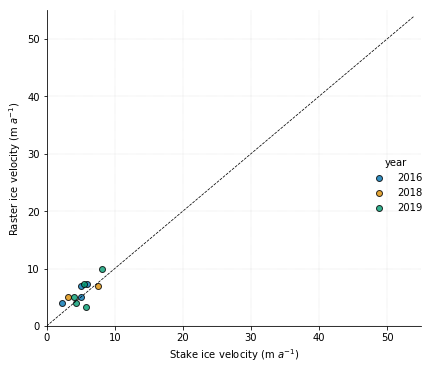

In [48]:
# for name in glacier:
#     V=dt[dt.glacier==name]
#     print
# for i in D.Year:
#     D.Year[i]=int(D.Year[i])


# plt.figure(figsize=(4,4))#(3.34,3.34))

# plt.plot(np.arange(0, 290), np.arange(0, 290), 'k--', linewidth=0.5, zorder=1)
import seaborn as sns
# Use the 'hue' argument to provide a factor variable
g= sns.lmplot( x="Velocity", y="vz", data=D, fit_reg=False, hue='year', legend=True, palette='colorblind',scatter_kws={'linewidths':1,'edgecolor':'k'})
# plt.scatter(D.velocity, D.vz, s=30, edgecolor='#3182bd', facecolor='#a6bddb', linewidth=1.4, label=D.Year)#, zorder=3)
plt.plot(np.arange(0, 55), np.arange(0, 55), 'k--', linewidth=0.75, zorder=1)
plt.xlabel('Stake ice velocity (m $a^{-1}$)')
plt.ylabel('Raster ice velocity (m $a^{-1}$)')
plt.xlim(0,55);plt.ylim(0,55)
# plt.legend(loc=2)
plt.grid(linestyle=':', linewidth=0.4, color='gray', alpha=0.5, zorder=0)
plt.tight_layout(pad=0.2)
# plt.savefig(loc+ 'products/Conrad_stake_vel_comp.png',dpi=300)
plt.show()



In [211]:
def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)

def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
#         fig, ax = plt.subplots(figsize=(15, 15))
#         rplt.show(raster, ax=ax)
#         reproj.plot(ax=ax, facecolor='none', edgecolor='red')
#         fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats